In [26]:
import pandas as pd
import scipy
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

## Create batting data set

First, we will import the raw dataset, that has yearly batting starts for all seasons from 1871 to 2018. We will filter out odd rows with `AB=0` and calculate the batting average for each player in the data set. 

Next, we will add the real name of the player from the `People` dataset for convenience. Lastly, we will filter out Pitchers in order to not have to deal with two distributions.

In [3]:
# create batting average dataset (sum over years)
batting = pd.read_csv("~/baseball/core/Batting.csv")
pitching = pd.read_csv("~/baseball/core/Pitching.csv")
# filter pitchers
batting_pitchers = batting.playerID.isin(pitching.playerID)
batting = batting[~batting_pitchers]
# sum over seasons
batting = batting.loc[batting["AB"] > 0].groupby("playerID").agg({"AB": "sum", "H": "sum"})
batting["average"] = batting["H"]/batting["AB"]

In [4]:
# add actual player name
people = pd.read_csv("~/baseball/core/People.csv")
people["name"] = people["nameFirst"] + " " + people["nameLast"]
batting = batting.merge(people[["playerID", "name"]], on="playerID")

In [5]:
batting.head()

,playerID,AB,H,average,name
0,aaronha01,12364,3771,0.304998,Hank Aaron
1,aaronto01,944,216,0.228814,Tommie Aaron
2,abadan01,21,2,0.095238,Andy Abad
3,abadijo01,49,11,0.224490,John Abadie
4,abbated01,3044,772,0.253614,Ed Abbaticchio


Let's plot the average distribution

In [7]:
# first filter out low sample players with less than 500 AB
batting_plot = batting[batting["AB"]>=500]

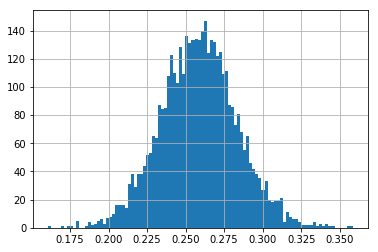

In [8]:
batting_plot["average"].hist(bins=100)

Let's fit a beta distribution to this data. For this we can use the scipy implementation of the beta distribution, which comes with a `.fit`-method. The scipy implementation comes with a general form of the beta distribution, we will manually set the lower (`floc`) and upper (`fscale`) bounds to 0 and 1.

In [59]:
param = st.beta.fit(batting_plot["average"].values, floc=0, fscale=1)

In [40]:
param

(79.50347694695064, 227.83242495205718, 0, 1)

In [51]:
alpha_0 = param[0]
beta_0 = param[1]

Let's plot out our data (with density) and our beta distribution with our fitted parameters:

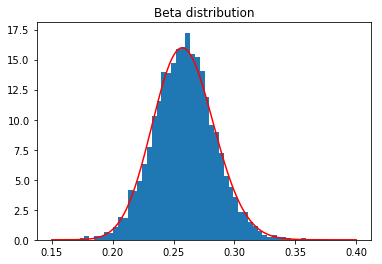

In [60]:
x = np.linspace(0.15,0.4,1000)
pdf_fitted = st.beta.pdf(x,a=param[0],b=param[1])
h = plt.hist(batting_plot["average"], density=True, bins=50)

plt.title('Beta distribution')
plt.plot(x,pdf_fitted,'r-')
plt.show()

Let's create a `eb_estimate` column in our batting data:

In [52]:
batting["eb_estimate"] = (batting["H"] + alpha_0) / (batting["AB"] + alpha_0 + beta_0)

In [53]:
batting.head()

,playerID,AB,H,average,name,eb_estimate
0,aaronha01,12364,3771,0.304998,Hank Aaron,0.303875
1,aaronto01,944,216,0.228814,Tommie Aaron,0.236150
2,abadan01,21,2,0.095238,Andy Abad,0.248232
3,abadijo01,49,11,0.224490,John Abadie,0.253984
4,abbated01,3044,772,0.253614,Ed Abbaticchio,0.254079


Let's plot the simple average and the empirical Bayes estimate in a scatter plot:

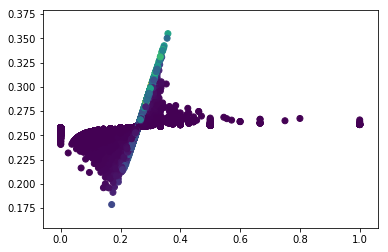

In [58]:
plt.scatter(batting["average"], batting["eb_estimate"], c=batting["AB"])

From this we can see that only the data points with large sample (large `AB`) lie on the diagonal. For most of the other data points we see a large amount of shrinka: we move our estimate quite a bit towards the average given by our empiracal Bayes estimate.